In [195]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [3]:
alpaca_api_key = "PKPOTQ9DJW12ODHW8FMR"
alpaca_secret_key = "4Zk4ZBfuOnhHEqoWbMdD7R1S0NGoFR5Gf9kdMy39"

In [4]:
print(f"Alpaca Key Type: {type(alpaca_api_key)}")
print(f"Alpaca Key Type: {type(alpaca_secret_key)}")

Alpaca Key Type: <class 'str'>
Alpaca Key Type: <class 'str'>


In [275]:
#Create the Alpaca API Object

alpaca = tradeapi.REST(
alpaca_api_key,
alpaca_secret_key,
api_version="v2")

In [276]:
#format current date as ISO format
today = pd.Timestamp("2020-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-04-01", tz="America/New_York").isoformat()

In [277]:
# Set timeframe to one day ('1D')for the Alpaca API

timeframe = "1D"

In [278]:
tickers= "TSLA"


In [279]:
#Get current price data for MSFT APPL

df = alpaca.get_barset(tickers, timeframe, start=today,end=end_date).df

df.head()

TSLA                                       
                             open      high      low     close    volume
time                                                                    
2020-01-02 00:00:00-05:00  424.95  430.6957  421.710  430.2400   9113793
2020-01-03 00:00:00-05:00  440.50  454.0000  436.920  442.7500  16409329
2020-01-06 00:00:00-05:00  440.47  451.5600  440.000  451.4001   9807049
2020-01-07 00:00:00-05:00  461.40  471.6300  453.355  469.1700  16859537
2020-01-08 00:00:00-05:00  473.70  498.4900  468.230  492.0900  29804104

In [280]:
df.columns

MultiIndex([('TSLA',   'open'),
            ('TSLA',   'high'),
            ('TSLA',    'low'),
            ('TSLA',  'close'),
            ('TSLA', 'volume')],
           )

In [281]:
tesla = df.xs('TSLA', axis=1)


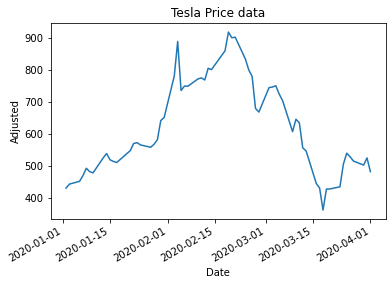

In [282]:
tesla["close"].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("Tesla Price data")
plt.show()


In [284]:
#feature engineering

#price change

close = tesla["close"].pct_change()
close = close.dropna()
close = pd.Series(close)
close = close.append(pd.Series(np.nan), ignore_index=True)
close = np.array(close)
tesla["pct_change of close"] = close

In [283]:
tesla

,open,high,low,close,volume
time,,,,,
2020-01-02 00:00:00-05:00,424.95,430.6957,421.710,430.2400,9113793
2020-01-03 00:00:00-05:00,440.50,454.0000,436.920,442.7500,16409329
2020-01-06 00:00:00-05:00,440.47,451.5600,440.000,451.4001,9807049
2020-01-07 00:00:00-05:00,461.40,471.6300,453.355,469.1700,16859537
2020-01-08 00:00:00-05:00,473.70,498.4900,468.230,492.0900,29804104
...,...,...,...,...,...
2020-03-26 00:00:00-04:00,547.39,560.0000,512.250,528.0500,16688863
2020-03-27 00:00:00-04:00,505.00,525.8000,494.030,514.5600,13608376
2020-03-30 00:00:00-04:00,510.26,516.6471,491.230,502.1000,11162231


<AxesSubplot:xlabel='time'>

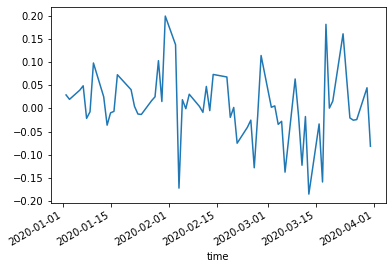

In [285]:
tesla["pct_change of close"].plot()

In [286]:
tesla["log_volume"] = np.log(tesla["volume"])

<AxesSubplot:xlabel='time'>

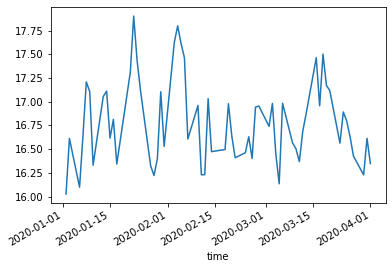

In [287]:
tesla["log_volume"].plot()

In [288]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import _tree
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [289]:
df.describe()

TSLA                                                  
             open        high         low       close        volume
count   63.000000   63.000000   63.000000   63.000000  6.300000e+01
mean   618.973040  642.518432  597.033630  619.400841  2.155460e+07
std    148.945915  152.544978  142.379525  146.727962  1.087797e+07
min    374.696500  404.860000  350.510000  361.600000  9.113793e+06
25%    499.175000  515.064950  491.615000  507.245000  1.379213e+07
50%    575.690000  594.500000  558.080000  569.430000  1.685954e+07
75%    736.420000  784.823050  717.090300  748.240400  2.618818e+07
max    923.500000  968.989900  901.020000  916.960000  5.968636e+07

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2020-01-02 00:00:00-05:00 to 2020-04-01 00:00:00-04:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (TSLA, open)    63 non-null     float64
 1   (TSLA, high)    63 non-null     float64
 2   (TSLA, low)     63 non-null     float64
 3   (TSLA, close)   63 non-null     float64
 4   (TSLA, volume)  63 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 3.0 KB


In [291]:
x = tesla[['high', 'low', 'open', 'volume']].values
y = tesla['close']

In [292]:
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)

In [293]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [294]:
print(reg.coef_)

[ 6.81658173e-01  8.05953335e-01 -4.80900670e-01 -9.05329453e-08]


In [295]:
print(reg.intercept_)

-0.7252945187767637


In [296]:
predicted = reg.predict(X_test)

In [297]:
y_test

time
2020-03-31 00:00:00-04:00    524.4800
2020-03-25 00:00:00-04:00    539.1750
2020-01-02 00:00:00-05:00    430.2400
2020-03-05 00:00:00-05:00    723.6200
2020-01-09 00:00:00-05:00    481.4900
2020-02-25 00:00:00-05:00    799.1100
2020-01-27 00:00:00-05:00    557.5400
2020-01-21 00:00:00-05:00    547.3007
2020-02-07 00:00:00-05:00    747.9808
2020-03-30 00:00:00-04:00    502.1000
2020-03-23 00:00:00-04:00    434.2900
2020-01-15 00:00:00-05:00    518.5050
2020-03-02 00:00:00-05:00    743.6900
2020-01-22 00:00:00-05:00    569.4300
2020-02-21 00:00:00-05:00    901.0000
2020-03-13 00:00:00-04:00    546.2000
2020-01-07 00:00:00-05:00    469.1700
2020-01-28 00:00:00-05:00    566.8200
2020-03-12 00:00:00-04:00    556.0100
Name: close, dtype: float64

In [66]:
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result

,close,predicted
0,524.4800,527.487369
1,539.1750,526.962472
2,430.2400,427.655597
3,723.6200,737.575920
4,481.4900,478.900323
5,799.1100,807.727876
6,557.5400,556.966766
7,547.3007,540.913542
8,747.9808,759.372370
9,502.1000,501.081302


In [70]:
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



Mean Absolute Error: 8.299955785757689
Mean Squared Error: 110.61404287618495
Root Mean Squared Error: 10.517321088384863


<AxesSubplot:>

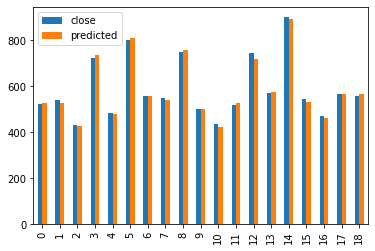

In [71]:
reg_result.plot(kind="bar")

In [73]:
tesla.head(1)

,open,high,low,close,volume,pct_change of close,log_volume
time,,,,,,,
2020-01-02 00:00:00-05:00,424.95,430.6957,421.71,430.24,9113793,NaN,16.0253


Mean Absolute Error: 9.142316934429067
Mean Squared Error: 176.8435806297217
Root Mean Squared Error: 13.298254796390454


<AxesSubplot:>

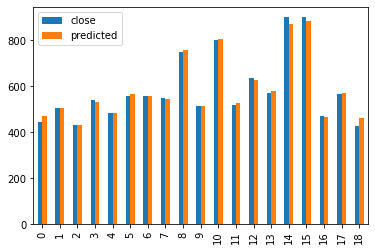

In [109]:
tesla_model2 = tesla.dropna()
x = tesla_model2[['high', 'low', 'open', 'volume','pct_change of close']].values
y = tesla_model2['close']
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
predicted = reg.predict(X_test)
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



reg_result.plot(kind="bar")

Mean Absolute Error: 9.264645412869601
Mean Squared Error: 191.61828280123453
Root Mean Squared Error: 13.842625574696244


<AxesSubplot:>

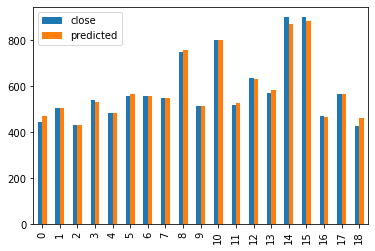

In [112]:
tesla_model3 = tesla.dropna()
x = tesla_model3[['high', 'low', 'open', 'log_volume']].values
y = tesla_model3['close']
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
predicted = reg.predict(X_test)
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



reg_result.plot(kind="bar")

Mean Absolute Error: 13.760666421282798
Mean Squared Error: 289.46203133898644
Root Mean Squared Error: 17.013583730037197


<AxesSubplot:>

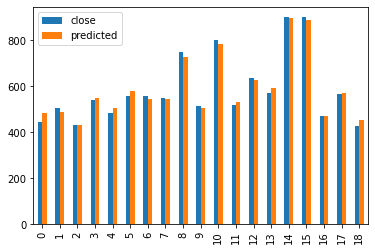

In [113]:
tesla_model4 = tesla.dropna()
x = tesla_model4[['open', 'volume','pct_change of close']].values
y = tesla_model4['close']
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
predicted = reg.predict(X_test)
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



reg_result.plot(kind="bar")

Random Selection of Points show the predcited values are closely aligned with the close values. We see that if the values are provided we can fairly accuractley calculate the close price of the day. We see that adding the previous dys percent cange does not increase predictive power of the model, additionally looking at the lof of volume also did not increase the modl predictiveness. 

# Random Forest Regression

Mean Absolute Error: 12.978017473683959
Mean Squared Error: 241.67664852413137
Root Mean Squared Error: 15.545952802068175


<AxesSubplot:>

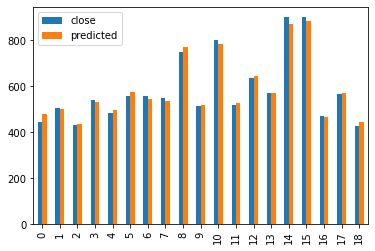

In [298]:
tesla_model = tesla.dropna()
x = tesla_model[['high', 'low', 'open', 'volume']].values
y = tesla_model['close']
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train,y_train)
predicted = reg.predict(X_test)
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



reg_result.plot(kind="bar")


In [299]:
tesla_model

,open,high,low,close,volume,pct_change of close,log_volume
time,,,,,,,
2020-01-02 00:00:00-05:00,424.95,430.6957,421.710,430.2400,9113793,0.029077,16.025300
2020-01-03 00:00:00-05:00,440.50,454.0000,436.920,442.7500,16409329,0.019537,16.613361
2020-01-06 00:00:00-05:00,440.47,451.5600,440.000,451.4001,9807049,0.039366,16.098612
2020-01-07 00:00:00-05:00,461.40,471.6300,453.355,469.1700,16859537,0.048852,16.640427
2020-01-08 00:00:00-05:00,473.70,498.4900,468.230,492.0900,29804104,-0.021541,17.210157
...,...,...,...,...,...,...,...
2020-03-25 00:00:00-04:00,545.25,557.0000,511.110,539.1750,19706795,-0.020633,16.796474
2020-03-26 00:00:00-04:00,547.39,560.0000,512.250,528.0500,16688863,-0.025547,16.630252
2020-03-27 00:00:00-04:00,505.00,525.8000,494.030,514.5600,13608376,-0.024215,16.426196


Mean Absolute Error: 13.57291010526293
Mean Squared Error: 239.27300565425531
Root Mean Squared Error: 15.468451947569134


<AxesSubplot:>

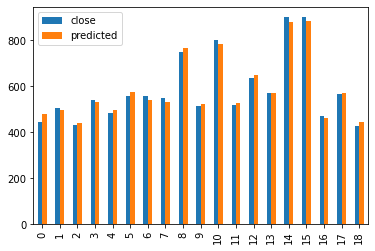

In [300]:
tesla_model = tesla.dropna()
x = tesla_model[['high', 'low', 'open', 'volume',"pct_change of close"]].values
y = tesla_model['close']
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    test_size=0.3, random_state=42)
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train,y_train)
predicted = reg.predict(X_test)
reg_result = pd.DataFrame(np.array(y_test))

reg_result["predicted"] = predicted
reg_result.columns = ["close","predicted"]
reg_result
print("Mean Absolute Error:", metrics.mean_absolute_error(reg_result.close,reg_result.predicted))
print("Mean Squared Error:", metrics.mean_squared_error(reg_result.close,reg_result.predicted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(reg_result.close,reg_result.predicted)))



reg_result.plot(kind="bar")



We see similar result with a random forest regression as we do in linear regression. Given the simplicity of the regression model, it is preferred. 

# ARIMA

In [179]:
tesla = df.xs('TSLA', axis=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

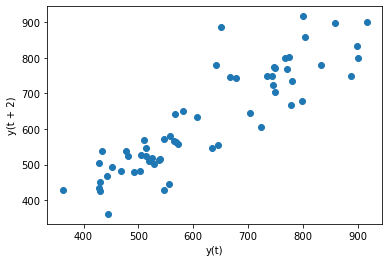

In [180]:
from pandas.plotting import lag_plot

plt.figure()
lag_plot(tesla["close"], lag=2)

In [181]:
tesla_test = tesla.iloc[-20:]
tesla_train = tesla.iloc[:-20]

In [182]:
model = ARIMA(tesla_train["close"],order=(1, 1, 0))

/Users/ryanlee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/ryanlee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [183]:
results = model.fit()

In [184]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                   42
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -220.778
Method:                       css-mle   S.D. of innovations             46.417
Date:                Mon, 05 Apr 2021   AIC                            447.557
Time:                        21:18:53   BIC                            452.770
Sample:                             1   HQIC                           449.467
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.6031      7.512      1.012      0.311      -7.120      22.326
ar.L1.D.close     0.0477      0.152      0.313      0.754      -0.251       0.346
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           20.9727           +0.0000j           20.9727            0.0000
-----------------------------------------------------------------------------
"""

In [185]:
forecasted = pd.DataFrame(results.forecast(steps=20)[0])

In [186]:
tesla_test["forecasted"] = np.array(forecasted)

<AxesSubplot:xlabel='time'>

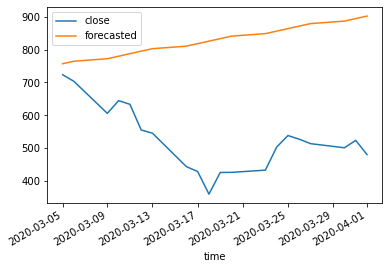

In [187]:
tesla_test[['close',"forecasted"]].plot()

In [188]:
print("Mean Absolute Error:", metrics.mean_absolute_error(tesla_test.close,tesla_test.forecasted))
print("Mean Squared Error:", metrics.mean_squared_error(tesla_test.close,tesla_test.forecasted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(tesla_test.close,tesla_test.forecasted)))



Mean Absolute Error: 302.4256146959055
Mean Squared Error: 107041.22994755562
Root Mean Squared Error: 327.17156041984396


given 3 months of data we see that the model is not predictive

In [236]:
#format current date as ISO format
start = pd.Timestamp("2015-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-04-01", tz="America/New_York").isoformat()
# Set timeframe to one day ('1D')for the Alpaca API

timeframe = "1D"
tickers= "TSLA"

df = alpaca.get_barset(tickers, timeframe, start=start,end=end_date, limit=1000).df


In [234]:
df

TSLA                                      
                             open      high       low   close    volume
time                                                                   
2016-04-13 00:00:00-04:00  248.51  255.5000  247.3300  254.53   4180730
2016-04-14 00:00:00-04:00  253.00  256.8390  251.0501  251.84   3507893
2016-04-15 00:00:00-04:00  251.31  254.6000  249.1200  254.45   3077318
2016-04-18 00:00:00-04:00  252.23  258.3100  251.6600  253.87   3632034
2016-04-19 00:00:00-04:00  253.12  254.3699  241.2510  247.37   5323758
...                           ...       ...       ...     ...       ...
2020-03-26 00:00:00-04:00  547.39  560.0000  512.2500  528.05  16688863
2020-03-27 00:00:00-04:00  505.00  525.8000  494.0300  514.56  13608376
2020-03-30 00:00:00-04:00  510.26  516.6471  491.2300  502.10  11162231
2020-03-31 00:00:00-04:00  501.25  542.9600  497.0000  524.48  16421035
2020-04-01 00:00:00-04:00  504.00  513.9548  475.1000  481.58  12570750

[1000 rows x 5 columns]

<AxesSubplot:xlabel='time'>

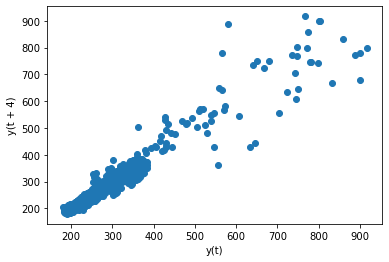

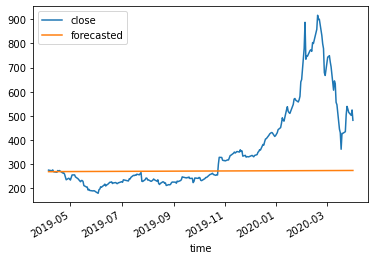

In [260]:
tesla = df.xs('TSLA', axis=1)
plt.figure()
lag_plot(tesla["close"], lag=4)
tesla_test = tesla.iloc[-250:]
tesla_train = tesla.iloc[:-250]
model = ARIMA(tesla_train["close"],order=(4, 1, 0))
results = model.fit()
results.summary()
forecasted = pd.DataFrame(results.forecast(steps=250)[0])
tesla_test["forecasted"] = np.array(forecasted)
tesla_test[['close',"forecasted"]].plot()


In [261]:
print("Mean Absolute Error:", metrics.mean_absolute_error(tesla_test.close,tesla_test.forecasted))
print("Mean Squared Error:", metrics.mean_squared_error(tesla_test.close,tesla_test.forecasted))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(tesla_test.close,tesla_test.forecasted)))




Mean Absolute Error: 122.78575957065117
Mean Squared Error: 37982.24257657151
Root Mean Squared Error: 194.8903347438541


One model is not very precitive, instead we will build a model for each time point and see how much better we see the values

In [250]:
train_data, test_data = tesla[0:700], tesla[700:]
training_data = train_data["close"].values
test_data = test_data['close'].values
history = [x for x in training_data]
model_pred = []
N_obs = len(test_data)



In [251]:
for timepoint in range(N_obs):
    model = ARIMA(history, order=(4,1,0))
    fit = model.fit()
    output = fit.forecast()
    pred = output[0]
    model_pred.append(pred)
    true_test_value = test_data[timepoint]
    history.append(true_test_value)


In [255]:
test_set_range = df[700:].index

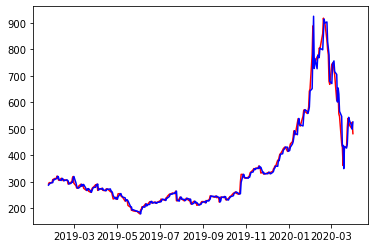

In [258]:
plt.plot(test_set_range,test_data, label="Actual", color = 'red')
plt.plot(test_set_range,model_pred, color="blue")


we see an almost perfect model which is a very exciting

In [263]:
print("Mean Absolute Error:", metrics.mean_absolute_error(test_data,model_pred))
print("Mean Squared Error:", metrics.mean_squared_error(test_data,model_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(test_data,model_pred)))




Mean Absolute Error: 11.41702759398021
Mean Squared Error: 570.5370709600535
Root Mean Squared Error: 23.885917837923948
